In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, precision_score, confusion_matrix, precision_recall_curve, roc_curve, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.inspection import permutation_importance
import seaborn as sns

Load boxscore_df

In [2]:
boxscore_df = pd.read_csv('boxscore_df')
#boxscore_df.head()

This makes sense. Most of the goals are scored by Attackers and Midfielders with a handful by Defenders and a couple by Goalies. I wonder what the counts by position are.

In [4]:
boxscore_df.groupby('position')['player_id'].count()

position
A    69311
D    73686
G    32902
M    72669
Name: player_id, dtype: int64

This also makes sense. Each team is typically comprised of three A's, M's, and D's with one G. 

Create a new df for the classifier to include only the stats that are being taken into consideration. Then remove all blank entries.

In [3]:
df = boxscore_df[['position',
       'goals', 'assists', 'points', 'shots', 'shots_on_goal',
       'ground_balls', 'turnovers',
       'caused_turnovers', 'faceoffs_won', 'faceoffs_taken', 'penalties',
       'penalty_time', 'goalie_seconds', 'goals_allowed', 'goalie_saves']]

df_noblanks = df[df['position'] != '']
df_noblanks = df_noblanks.dropna()

In [4]:
df.dtypes

position            object
goals                int64
assists              int64
points               int64
shots                int64
shots_on_goal        int64
ground_balls         int64
turnovers            int64
caused_turnovers     int64
faceoffs_won         int64
faceoffs_taken       int64
penalties            int64
penalty_time         int64
goalie_seconds       int64
goals_allowed        int64
goalie_saves         int64
dtype: object

In [30]:
df_noblanks.columns

Index(['position', 'goals', 'assists', 'points', 'shots', 'shots_on_goal',
       'ground_balls', 'turnovers', 'caused_turnovers', 'faceoffs_won',
       'faceoffs_taken', 'penalties', 'penalty_time', 'goalie_seconds',
       'goals_allowed', 'goalie_saves'],
      dtype='object')

Compare the shapes of the overall df to the one without blanks.

In [5]:
df.shape, df_noblanks.shape

((1180290, 16), (248616, 16))

~21% of the data points are not blank. Although, that's a low percentage, it's based on 1.1 millions rows of data. There are plenty of data points to train and test on.

In [4]:
X = df_noblanks.drop('position', axis=1).values
y = df_noblanks['position'].values

Chose not to scale the data first. Would it make a difference? Maybe check later...

Create training and testing sets with default parameters

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

180 neighbors yields the highest score

fit Knn with default parms... weights = uniform

In [6]:
knn = KNeighborsClassifier(n_neighbors=180)
knn.fit(X_train, y_train)
#print('knn unif training accuracy: {:.4f}'.format(knn.score(X_train,y_train)))
#print('knn unif test accuracy: {:.4f}'.format(knn.score(X_test, y_test)))

KNeighborsClassifier(n_neighbors=180)

Do a classification report and confusion matrix

In [7]:
y_pred = knn.predict(X_test)

In [8]:
y_pred[:5]

array(['A', 'M', 'D', 'A', 'M'], dtype=object)

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.66      0.77      0.71     14006
           D       0.77      0.95      0.85     14742
           G       1.00      1.00      1.00      6471
           M       0.64      0.39      0.48     14505

    accuracy                           0.74     49724
   macro avg       0.77      0.78      0.76     49724
weighted avg       0.73      0.74      0.72     49724



In [9]:
conf_matr = confusion_matrix(y_test, y_pred)
conf_matr

array([[10761,   739,     4,  2502],
       [  109, 13971,     8,   654],
       [    5,    17,  6446,     3],
       [ 5481,  3397,     0,  5627]], dtype=int64)

<Axes: >

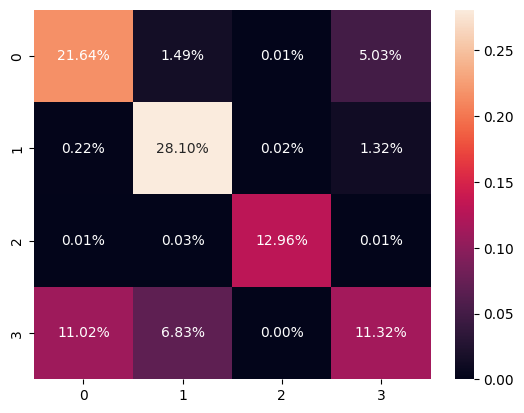

In [12]:
sns.heatmap(conf_matr/np.sum(conf_matr), annot=True, fmt='.2%')

In [12]:
len(y_pred)

49724

Text(0.5, 1.0, 'Figure 2: Confusion Matrix- kNN model, weights=uniform')

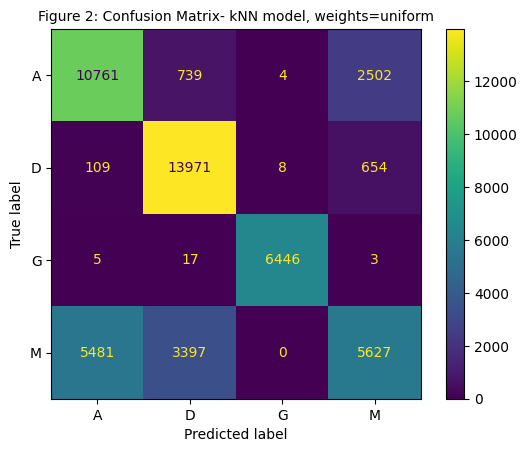

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Figure 2: Confusion Matrix- kNN model, weights=uniform', fontsize=10)


Find examples of errors

In [14]:
cols = ['goals', 'assists', 'points', 'shots', 'shots_on_goal',
       'ground_balls', 'turnovers',
       'caused_turnovers', 'faceoffs_won', 'faceoffs_taken', 'penalties',
       'penalty_time', 'goalie_seconds', 'goals_allowed', 'goalie_saves']
errorcheck_df = pd.DataFrame(X_test, columns=cols)
errorcheck_df['pos_true'] = y_test
errorcheck_df['pos_pred'] = y_pred
errorcheck_df.head()

,goals,assists,points,shots,shots_on_goal,ground_balls,turnovers,caused_turnovers,faceoffs_won,faceoffs_taken,penalties,penalty_time,goalie_seconds,goals_allowed,goalie_saves,pos_true,pos_pred
0,3,2,5,11,8,4,2,0,0,0,0,0,0,0,0,A,A
1,0,0,0,0,0,0,0,0,4,11,0,0,0,0,0,M,M
2,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,M,D
3,2,2,4,9,5,0,4,0,0,0,0,0,0,0,0,A,A
4,0,0,0,0,0,2,0,0,6,15,0,0,0,0,0,M,M


Create new column showing whether the true position equals the predicted position

In [19]:
def no_pred(row):
    if row['pos_true'] == row['pos_pred']:
        return True
    
errorcheck_df['no_pred'] = errorcheck_df.apply(no_pred, axis=1)
errorcheck_df.head(10)

,goals,assists,points,shots,shots_on_goal,ground_balls,turnovers,caused_turnovers,faceoffs_won,faceoffs_taken,penalties,penalty_time,goalie_seconds,goals_allowed,goalie_saves,pos_true,pos_pred,no_pred
0,3,2,5,11,8,4,2,0,0,0,0,0,0,0,0,A,A,True
1,0,0,0,0,0,0,0,0,4,11,0,0,0,0,0,M,M,True
2,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,M,D,None
3,2,2,4,9,5,0,4,0,0,0,0,0,0,0,0,A,A,True
4,0,0,0,0,0,2,0,0,6,15,0,0,0,0,0,M,M,True
5,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,D,D,True
6,5,3,8,14,10,4,3,0,0,0,0,0,0,0,0,M,A,None
7,1,1,2,4,1,0,0,0,0,0,0,0,0,0,0,A,M,None
8,0,0,0,0,0,3,1,0,1,1,0,0,0,0,0,D,D,True
9,0,1,1,1,1,0,2,0,0,0,0,0,0,0,0,M,A,None


filter on results where prediction is incorrect

In [22]:
incor_pred = errorcheck_df[errorcheck_df['no_pred'] != True]
incor_pred2 = incor_pred[incor_pred['pos_pred'] == 'G']
incor_pred2.head(20)

,goals,assists,points,shots,shots_on_goal,ground_balls,turnovers,caused_turnovers,faceoffs_won,faceoffs_taken,penalties,penalty_time,goalie_seconds,goals_allowed,goalie_saves,pos_true,pos_pred,no_pred
1805,0,0,0,0,0,1,0,1,0,0,0,0,3600,12,11,D,G,None
7608,0,0,0,0,0,4,2,0,0,0,0,0,1800,12,5,A,G,None
8551,0,0,0,1,0,2,0,0,0,0,0,0,236,0,1,D,G,None
12420,0,0,0,0,0,0,2,2,0,0,1,60,2637,7,11,D,G,None
19024,0,0,0,0,0,4,4,0,0,0,0,0,3600,19,11,D,G,None
21575,0,0,0,0,0,2,0,0,0,0,0,0,3600,13,16,D,G,None
29739,0,0,0,0,0,1,0,0,0,0,0,0,3600,7,6,D,G,None
34021,0,1,1,0,0,2,0,0,0,0,0,0,2123,10,8,A,G,None
35650,0,0,0,0,0,1,0,0,0,0,0,0,3840,11,9,D,G,None
39259,0,0,0,0,0,0,0,0,0,0,0,0,2700,12,7,D,G,None


After several iterations of ablation for four models and neighbor testing, the best is knn, uniform, 180 neighbors, with 80% training. Let's check the cross validation score

What's the permutation importance of features on a sample of 10k based on position
G = 1324, A = 2788, D = 2964, M = 2924

Let's put X_train into a df and pull these samples to see what the results are 

In [8]:
xtr_df = pd.DataFrame(X_train, columns=['goals', 'assists', 'points', 'shots', 'shots_on_goal',
       'ground_balls', 'turnovers',
       'caused_turnovers', 'faceoffs_won', 'faceoffs_taken', 'penalties',
       'penalty_time', 'goalie_seconds', 'goals_allowed', 'goalie_saves'])

In [9]:
#trained_df = pd.concat([xtr_df, y_train.to_frame().T], axis=1, ignore_index=True)
#trained_df.head()
xtr_df['position'] = y_train

In [17]:
xtr_df.shape

(198892, 16)

In [10]:
train_g = xtr_df[xtr_df['position'] == 'G'].sample(1324)
train_a = xtr_df[xtr_df['position'] == 'A'].sample(2788)
train_d = xtr_df[xtr_df['position'] == 'D'].sample(2964)
train_m = xtr_df[xtr_df['position'] == 'M'].sample(2924)


In [12]:
trained_df = pd.concat([train_a, train_d, train_g, train_m])
trained_df.head()

,goals,assists,points,shots,shots_on_goal,ground_balls,turnovers,caused_turnovers,faceoffs_won,faceoffs_taken,penalties,penalty_time,goalie_seconds,goals_allowed,goalie_saves,position
14976,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,A
75151,2,1,3,4,3,0,0,0,0,0,0,0,0,0,0,A
180783,4,0,4,6,6,1,1,1,0,0,0,0,0,0,0,A
185698,4,1,5,6,4,0,1,0,0,0,0,0,0,0,0,A
121683,0,2,2,0,0,0,1,0,0,0,0,0,0,0,0,A


In [13]:
permX = trained_df.drop('position', axis=1).values
permy = trained_df['position'].values
permcols = trained_df.drop('position', axis=1)

In [14]:
permyimp = permutation_importance(knn, permX, permy, scoring='accuracy', random_state=42)
permyimp

{'importances_mean': array([ 8.5200e-03,  1.0460e-02,  3.9600e-02,  1.0578e-01,  4.9160e-02,
         8.3000e-03,  9.3200e-03,  7.1200e-03,  7.8600e-03,  2.6880e-02,
        -6.0000e-05,  3.1400e-03,  1.9402e-01, -6.0000e-05, -1.6000e-04]),
 'importances_std': array([0.00234043, 0.00135144, 0.00359444, 0.00224802, 0.00343837,
        0.00175841, 0.00096623, 0.00126238, 0.00129861, 0.0009239 ,
        0.00016248, 0.00130169, 0.0014905 , 0.00025768, 0.00052383]),
 'importances': array([[ 7.000e-03,  1.100e-02,  5.700e-03,  7.300e-03,  1.160e-02],
        [ 9.100e-03,  9.200e-03,  1.120e-02,  1.270e-02,  1.010e-02],
        [ 3.390e-02,  3.880e-02,  4.510e-02,  3.950e-02,  4.070e-02],
        [ 1.038e-01,  1.029e-01,  1.059e-01,  1.091e-01,  1.072e-01],
        [ 4.580e-02,  4.590e-02,  5.430e-02,  5.210e-02,  4.770e-02],
        [ 7.900e-03,  1.140e-02,  6.000e-03,  7.700e-03,  8.500e-03],
        [ 9.500e-03,  9.000e-03,  1.080e-02,  9.500e-03,  7.800e-03],
        [ 8.600e-03,  7.400e-

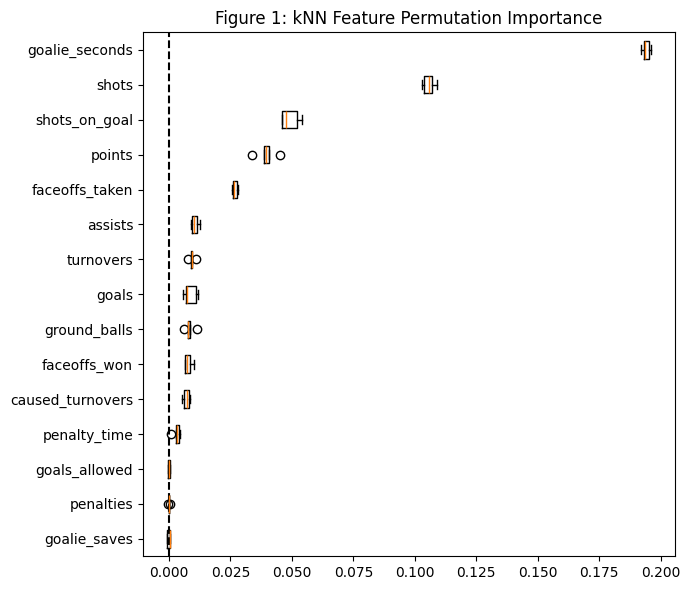

In [16]:
#better to use this in the preso as it better represents the sample
permy_sorted_idx = permyimp.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(7, 6))
ax.boxplot(
        permyimp.importances[permy_sorted_idx].T,
        vert=False,
        labels=permcols.columns[permy_sorted_idx],
    )
ax.set_title('Figure 1: kNN Feature Permutation Importance')
ax.axvline(x=0, color="k", linestyle="--")
_ = ax.figure.tight_layout()

As you can see, there are several features that aren't important. Let's take them out and check the viz again.

In [39]:
permX_imp = trained_df.drop(['position','penalties','goalie_saves','goals_allowed','penalty_time','caused_turnovers','faceoffs_won'], axis=1).values
permy_imp = trained_df['position'].values
permcols_imp = trained_df.drop(['position','penalties','goalie_saves','goals_allowed','penalty_time','caused_turnovers','faceoffs_won'], axis=1)

In [ ]:
xtr_df

In [42]:
#X = df_noblanks.drop('position', axis=1).values
#y = df_noblanks['position'].values
X_train_imp = xtr_df.drop(['position','penalties','goalie_saves','goals_allowed','penalty_time','caused_turnovers','faceoffs_won'], axis=1).values
knn_imp = KNeighborsClassifier(n_neighbors=180)
knn_imp.fit(X_train_imp, y_train)

KNeighborsClassifier(n_neighbors=180)

In [43]:
permyimp2 = permutation_importance(knn_imp, permX_imp, permy_imp, scoring='accuracy', random_state=42)
permyimp2

{'importances_mean': array([0.00798, 0.01266, 0.05016, 0.11374, 0.06234, 0.01676, 0.01304,
        0.05676, 0.19502]),
 'importances_std': array([0.00146068, 0.00117915, 0.00273978, 0.00221684, 0.00099519,
        0.00136323, 0.00150811, 0.00084994, 0.00130752]),
 'importances': array([[0.0069, 0.0071, 0.008 , 0.0108, 0.0071],
        [0.0125, 0.0116, 0.0112, 0.0142, 0.0138],
        [0.0525, 0.0456, 0.0514, 0.0528, 0.0485],
        [0.1101, 0.1155, 0.1122, 0.1155, 0.1154],
        [0.0612, 0.0638, 0.0613, 0.063 , 0.0624],
        [0.0153, 0.0161, 0.0184, 0.0184, 0.0156],
        [0.012 , 0.0107, 0.0143, 0.0148, 0.0134],
        [0.0562, 0.0571, 0.0555, 0.057 , 0.058 ],
        [0.1963, 0.1939, 0.1946, 0.1968, 0.1935]])}

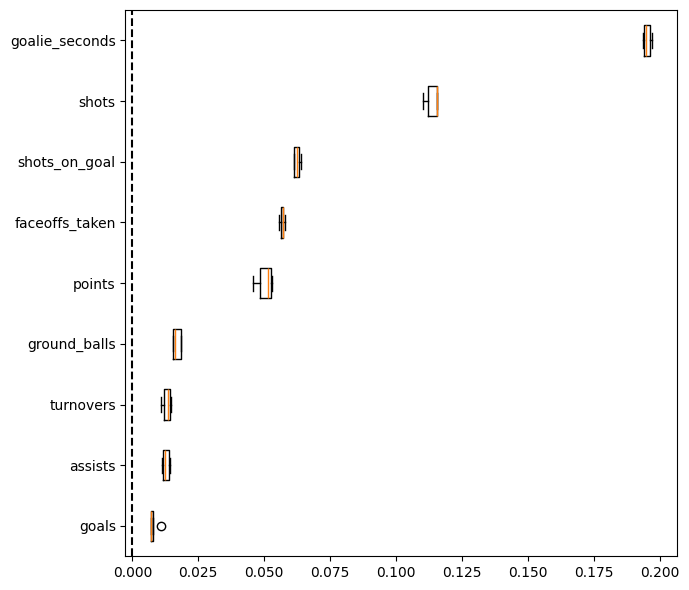

In [46]:
permy_imp_sorted_idx = permyimp2.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(7, 6))
ax.boxplot(
        permyimp2.importances[permy_imp_sorted_idx].T,
        vert=False,
        labels=permcols_imp.columns[permy_imp_sorted_idx],
    )
ax.axvline(x=0, color="k", linestyle="--")
_ = ax.figure.tight_layout()

Yep, as expected

In [36]:
X_train_1k = X_train[:1000]
y_train_1k = y_train[:1000]

In [37]:
permimp = permutation_importance(knn, X_train_1k, y_train_1k, scoring='accuracy', random_state=42)
permimp

{'importances_mean': array([ 0.0114,  0.004 ,  0.0426,  0.1028,  0.041 ,  0.006 ,  0.0142,
         0.006 ,  0.003 ,  0.0258,  0.001 ,  0.0116,  0.1812, -0.0004,
        -0.0002]),
 'importances_std': array([0.00402989, 0.00260768, 0.00564269, 0.01287478, 0.00368782,
        0.00576194, 0.00285657, 0.00328634, 0.00296648, 0.00556417,
        0.00063246, 0.00313688, 0.0069685 , 0.00149666, 0.00116619]),
 'importances': array([[ 0.006,  0.018,  0.011,  0.013,  0.009],
        [ 0.006,  0.002,  0.   ,  0.007,  0.005],
        [ 0.038,  0.045,  0.034,  0.048,  0.048],
        [ 0.093,  0.088,  0.101,  0.107,  0.125],
        [ 0.04 ,  0.041,  0.048,  0.038,  0.038],
        [ 0.007,  0.007,  0.006, -0.004,  0.014],
        [ 0.019,  0.016,  0.012,  0.012,  0.012],
        [ 0.009,  0.009,  0.006,  0.006,  0.   ],
        [ 0.   , -0.001,  0.006,  0.006,  0.004],
        [ 0.02 ,  0.024,  0.021,  0.035,  0.029],
        [ 0.001,  0.001,  0.002,  0.001,  0.   ],
        [ 0.013,  0.01 ,  0.0

Note to self...do not do 10 n_repeats

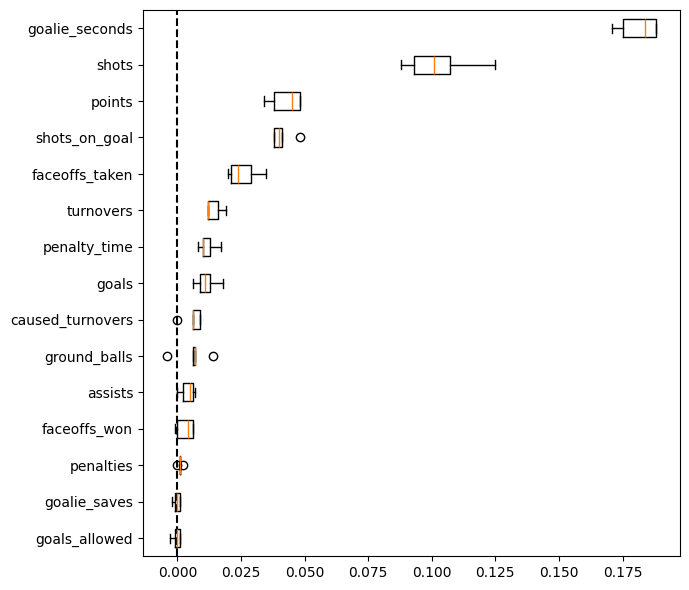

In [38]:

#used in presentation
perm_sorted_idx = permimp.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(7, 6))
ax.boxplot(
        permimp.importances[perm_sorted_idx].T,
        vert=False,
        labels=permcols.columns[perm_sorted_idx],
    )
ax.set_title('kNN Feature Permutation Importance')
ax.axvline(x=0, color="k", linestyle="--")
_ = ax.figure.tight_layout()

In [10]:
X_train_year1 = X_train[:130000]
y_train_year1 = y_train[:130000]

In [11]:
permimp_yr1 = permutation_importance(knn, X_train_year1, y_train_year1, scoring='accuracy', random_state=42)
permimp_yr1

{'importances_mean': array([9.49538462e-03, 9.94461538e-03, 3.97784615e-02, 1.05124615e-01,
        5.11461538e-02, 1.12861538e-02, 1.46461538e-02, 7.73846154e-03,
        8.08769231e-03, 2.73676923e-02, 1.36923077e-04, 5.50615385e-03,
        1.97044615e-01, 9.84615385e-05, 7.23076923e-05]),
 'importances_std': array([5.38606574e-04, 4.21617062e-04, 5.71086373e-04, 1.21664394e-03,
        6.83811109e-04, 2.66975167e-04, 1.55224594e-04, 2.42326007e-04,
        2.47907217e-04, 6.43408086e-04, 2.54660698e-05, 4.09918451e-04,
        5.51692393e-04, 8.47411653e-05, 1.37311463e-04]),
 'importances': array([[ 9.61538462e-03,  9.70769231e-03,  9.08461538e-03,
          8.75384615e-03,  1.03153846e-02],
        [ 1.07461538e-02,  9.68461538e-03,  9.73846154e-03,
          9.57692308e-03,  9.97692308e-03],
        [ 3.98153846e-02,  4.06384615e-02,  3.91692308e-02,
          3.91461538e-02,  4.01230769e-02],
        [ 1.05569231e-01,  1.04876923e-01,  1.03300000e-01,
          1.04823077e-01, 

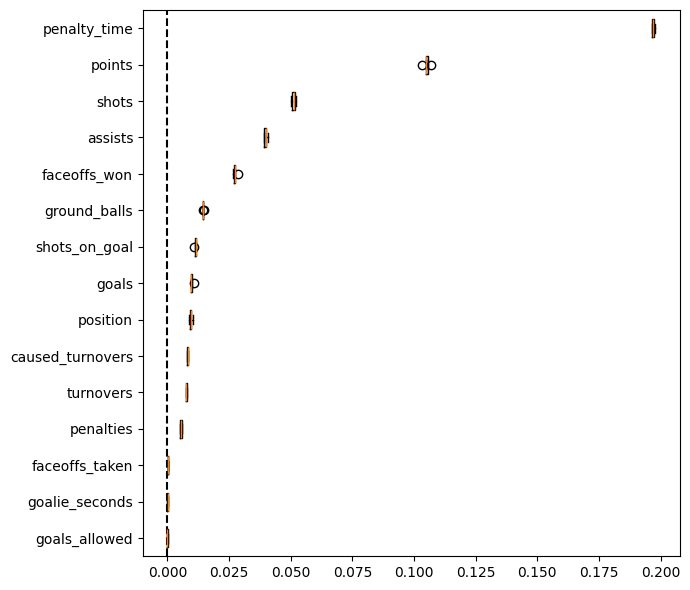

In [12]:
perm_sorted_idx_yr1 = permimp_yr1.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(7, 6))
ax.boxplot(
        permimp_yr1.importances[perm_sorted_idx_yr1].T,
        vert=False,
        labels=df_noblanks.columns[perm_sorted_idx_yr1],
    )
ax.axvline(x=0, color="k", linestyle="--")
_ = ax.figure.tight_layout()